# Moving Average Crossover Strategy

In this project I will use both simple and exponential moving averages to determine whether to buy or sell

### Simple Moving Average

It uses the average of closing prices over a period of time. Using the formula:
$$\text{SMA} = \frac{A_1 + A_2 + \dots +A_n}{n}$$
Where:
- $A_n$ is the closing price of an asset
- $n$ is the number of periods

### Exponential Moving Average

This moving average puts more significance on the most recent values. Using hte formula:
$$\text{EMA}_\text{Today} = (\text{Value}_\text{Today} * (\frac{\text{Smoothing}}{1 + \text{Days}}))+ \text{EMA}_\text{Yesterday}*(1-(\frac{\text{Smoothing}}{1+\text{Days}}))$$
Where:
- Smoothing = 2 (this is the most common choice)

## Importing Libraries

In [39]:
import yfinance as yf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Implementing the Strategies

### Fetch data

In [40]:
# Fetch historical stock data
symbol = 'TSM'
data = yf.download(symbol, period="2y",progress=False)
data.index = pd.to_datetime(data.index)

# Convert data to DataFrame
df = pd.DataFrame(data.copy())

# Display the first few rows of data
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSM,TSM,TSM,TSM,TSM,TSM
Date,,,,,,
2022-12-21,74.849922,77.139999,77.419998,75.769997,75.860001,10806100
2022-12-22,73.045151,75.279999,76.430000,74.019997,76.279999,13019700
2022-12-23,72.666718,74.889999,75.349998,74.169998,74.889999,7452600
2022-12-27,72.113647,74.320000,74.739998,74.160004,74.330002,8974800
2022-12-28,70.891045,73.059998,74.550003,72.839996,74.190002,10275700


### Moving Averages

Explain why we need to get these

In [41]:
df['50-Day SMA'] = df['Close'].rolling(window=50).mean()
df['200-Day SMA'] = df['Close'].rolling(window=200).mean()

# Calculate EMA
df['50-Day EMA'] = df['Close'].ewm(span=50, adjust=False).mean()
df['200-Day EMA'] = df['Close'].ewm(span=200, adjust=False).mean()

### Buy and Sell Signals

Explain this here

In [44]:
df['Signal SMA'] = np.where(df['50-Day SMA'] > df['200-Day SMA'], 1, 0)
df['Position SMA'] = df['Signal SMA'].diff()

df['Signal EMA'] = np.where(df['50-Day EMA'] > df['200-Day EMA'], 1, 0)
df['Position EMA'] = df['Signal EMA'].diff()


### Plotting SMA

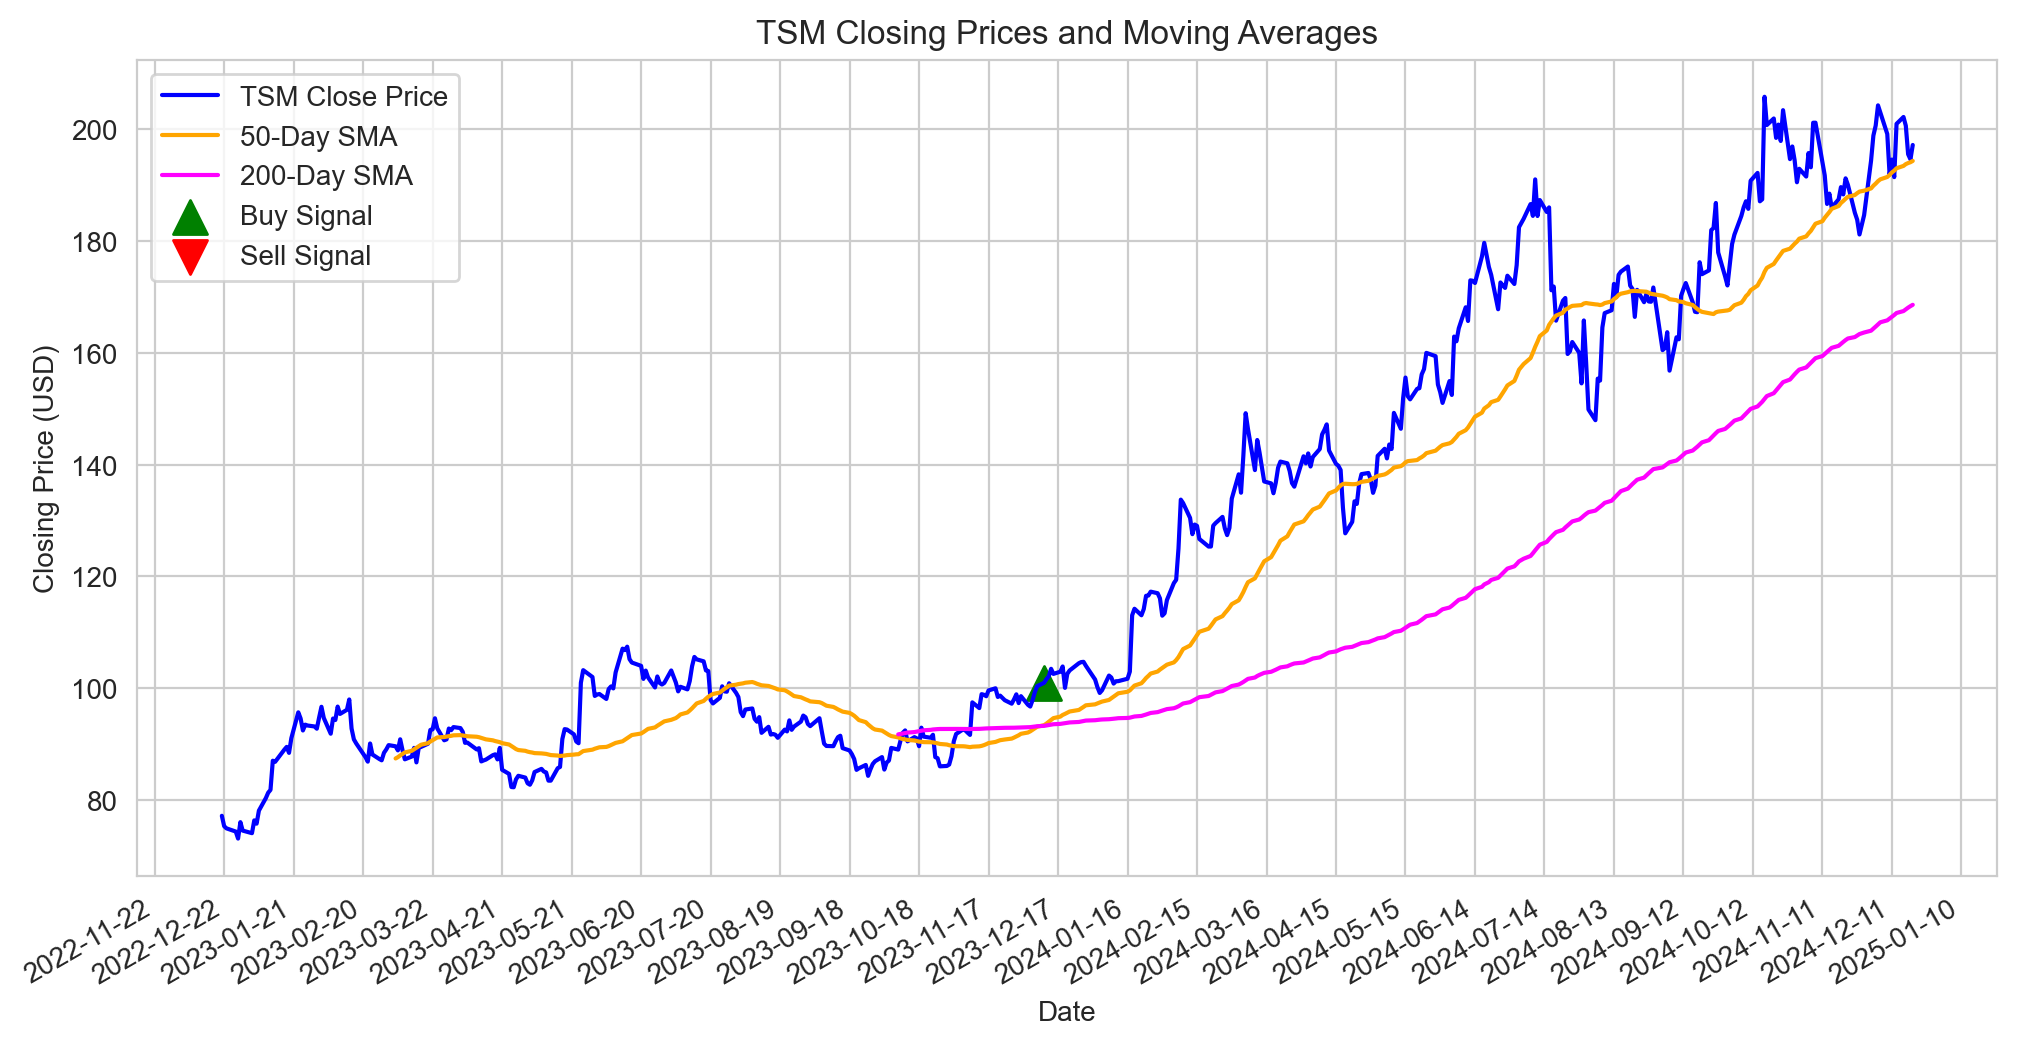

In [45]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)  # Set figure size
fig.autofmt_xdate()

# Format the x-axis
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))  # Intervals of a month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Plot with Seaborn (use index for x-axis)

close_values = df.Close.values.flatten() # Make close 1D for seaborn
sns.lineplot(x=df.index, y=close_values, label=f'{symbol} Close Price', ax=ax, color='blue')
sns.lineplot(x=df.index, y=df['50-Day SMA'], label='50-Day SMA', ax=ax, color='orange')
sns.lineplot(x=df.index, y=df['200-Day SMA'], label='200-Day SMA', ax=ax, color='magenta')

## PLot Buy Markers
buy_signals = df[df['Position SMA'] == 1]
sell_signals = df[df['Position SMA'] == -1]

ax.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', marker='^', color='green', s=150)
ax.scatter(sell_signals.index, sell_signals['Close'], label='Sell Signal', marker='v', color='red', s=150)

# Add titles and labels
ax.set_title(f'{symbol} Closing Prices and Moving Averages')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')

ax.legend(loc='best', fontsize=10)


plt.show()



### Plotting EMA

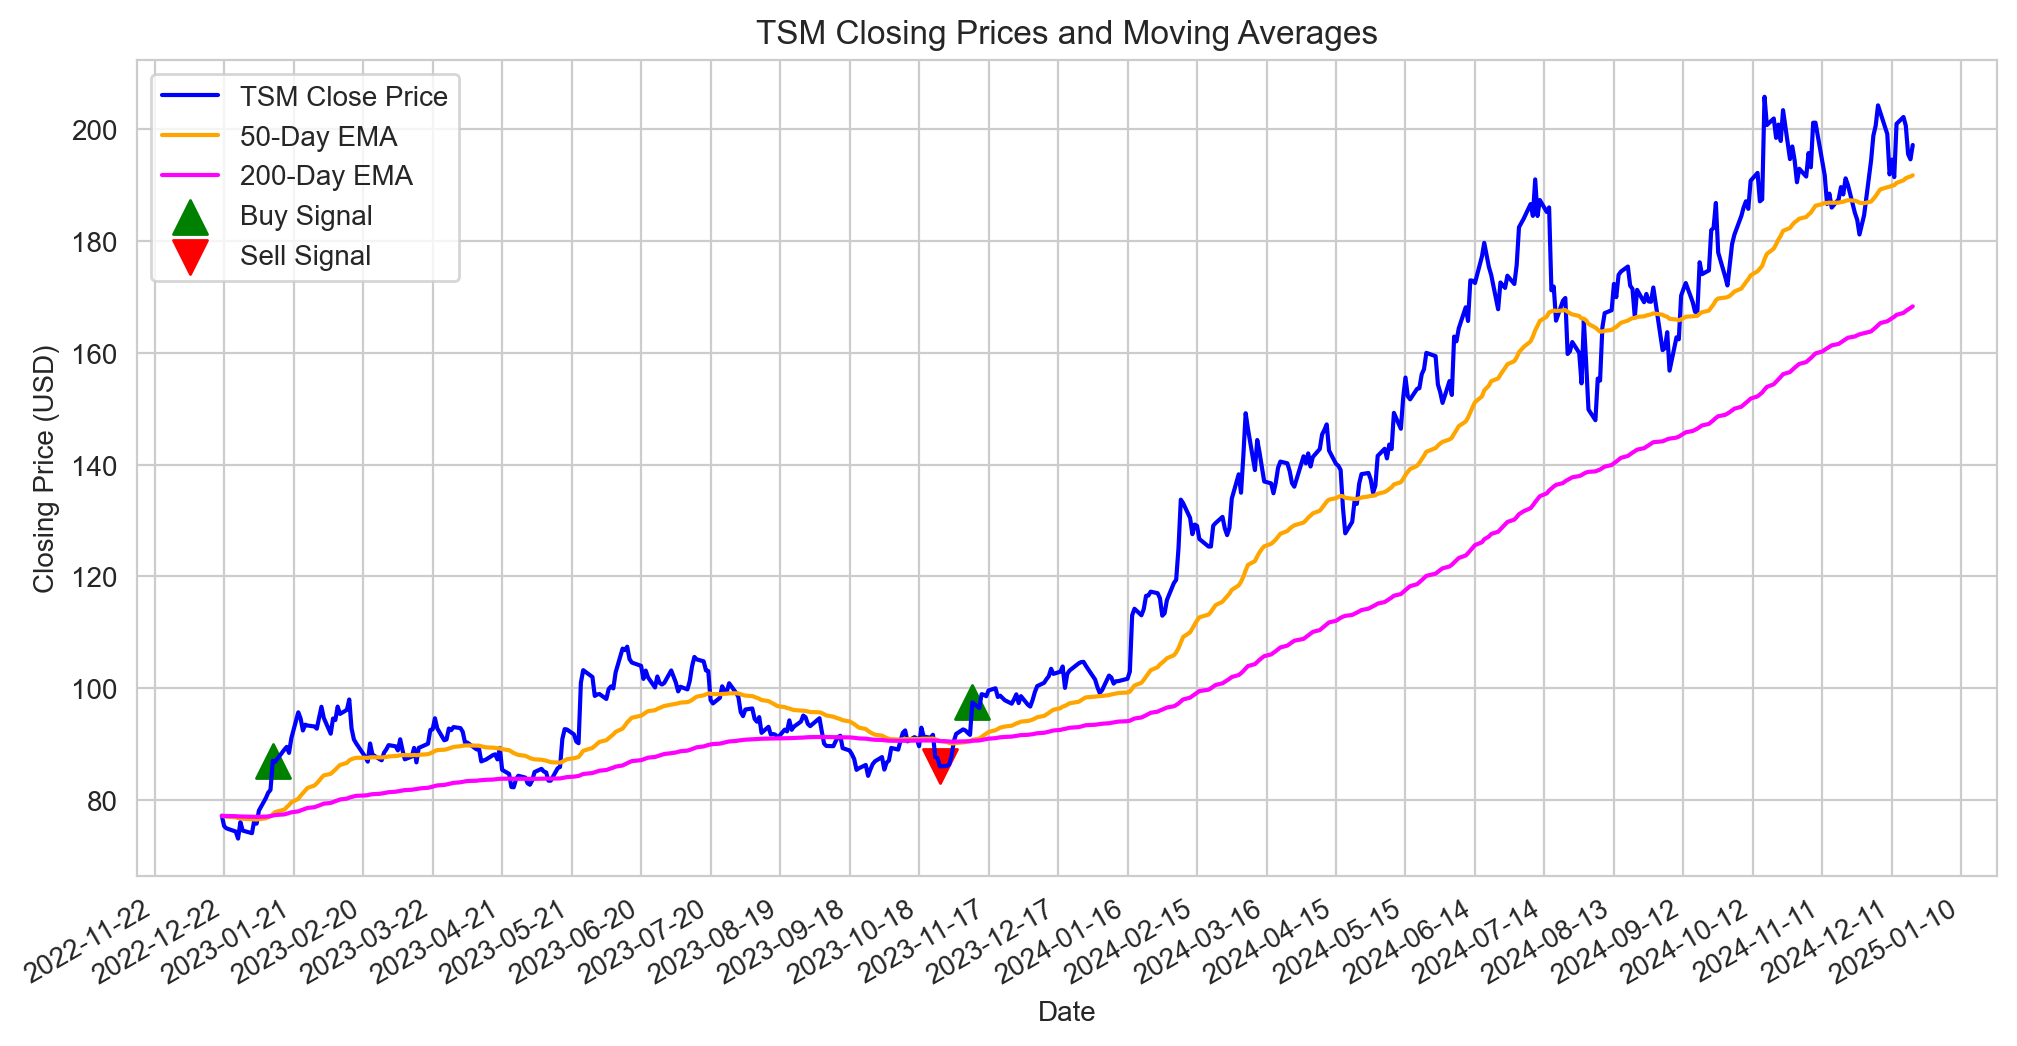

In [46]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)  # Set figure size
fig.autofmt_xdate()

# Format the x-axis
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))  # Intervals of a month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Plot with Seaborn (use index for x-axis)

close_values = df.Close.values.flatten() # Make close 1D for seaborn
sns.lineplot(x=df.index, y=close_values, label=f'{symbol} Close Price', ax=ax, color='blue')
sns.lineplot(x=df.index, y=df['50-Day EMA'], label='50-Day EMA', ax=ax, color='orange')
sns.lineplot(x=df.index, y=df['200-Day EMA'], label='200-Day EMA', ax=ax, color='magenta')

## PLot Buy Markers
buy_signals = df[df['Position EMA'] == 1]
sell_signals = df[df['Position EMA'] == -1]

ax.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', marker='^', color='green', s=150)
ax.scatter(sell_signals.index, sell_signals['Close'], label='Sell Signal', marker='v', color='red', s=150)

# Add titles and labels
ax.set_title(f'{symbol} Closing Prices and Moving Averages')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')

ax.legend(loc='best', fontsize=10)


plt.show()

